# Import Needed Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import os
import shutil
import PIL
import cv2
import random
import dlib
from scipy import ndimage
from datetime import datetime

## Set things up

In [2]:
RANDOM_SEED = 123

# Check Database
Show what images are in there

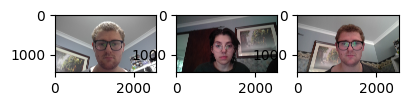

In [3]:
# define location of datasets
pred_img = 'hotf\original'

#plot 9 random images
pi_list = []


for (dirp, dirn, filen) in os.walk(pred_img):
    pi_list.extend(filen)
    break

plt.figure(figsize=(len(pi_list)*2,len(pi_list)))

break_iter = 0
for iter,file in enumerate(pi_list):
    plt.subplot(1+len(pi_list)//3,1+len(pi_list)%5,iter+1)
    # define filename
    # load image pixels
    image = plt.imread(os.path.join(pred_img,file))
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

# Organise the Images

## Bring in Function to Align Face and Crop
Using the function liam wrote to ensure consistant data

In [4]:
# Initialize the Dlib face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
failed_to_crop = 0
no_face_detected = 0


# Function to detect and align faces in an image
def align_and_crop_face(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    # Check if a face is detected
    if len(faces) > 0:
        # Assume there's only one face in the image for simplicity
        face = faces[0]

        # Get the facial landmarks for face alignment
        shape = predictor(gray, face)

        # Define the coordinates for the eyes
        left_eye = shape.part(36)  # Left eye
        right_eye = shape.part(45)  # Right eye

        # Calculate the angle for rotation (to make eyes horizontal)
        angle = np.arctan2(right_eye.y - left_eye.y, right_eye.x - left_eye.x)
        angle = np.degrees(angle)

        # Rotate and crop the face
        rotated_image = ndimage.rotate(image, angle, mode='nearest')
        cropped_face = rotated_image[face.top():face.bottom(), face.left():face.right()]

        # Check if the cropped face is not empty
        if not cropped_face.size == 0:
            # Save the aligned and cropped face
            cv2.imwrite(output_path, cropped_face)
        else:
            global failed_to_crop
            failed_to_crop += 1
    else:
        global no_face_detected
        no_face_detected += 1

## Crop the Faces and Relocate

In [5]:
#%%script false

# Clean the Crop and Data Directory

cropped = "hotf\cropped"
data_home = "hotf\data\data"

clean_lst = [cropped,data_home]

for dir in clean_lst:
    if os.path.exists(dir):
        # Remove all files in the directory
        for filename in os.listdir(dir):
            file_path = os.path.join(dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Error cleaning {file_path}: {e}")
    else:
            print(f"The directory {cropped} does not exist.")


test_ratio = 0.1 

failed_to_crop = 0
no_face_detected = 0

# Now Crop the original images and put into cropped
for iter,file in enumerate(os.listdir(pred_img)):
    src = os.path.join(pred_img, file)
    crp = os.path.join(cropped, file)
    dat = os.path.join(data_home, file)
    
    align_and_crop_face(src,crp)
    
    # No name and age data, tese will just be cropped and put into the folder  
    photo = tf.keras.utils.load_img(crp, target_size=(200, 200))
    photo.save(dat)  
    
      
    
print(f"{failed_to_crop} Images failed to crop")
print(f"{no_face_detected} Images without a detectable face")

0 Images failed to crop
0 Images without a detectable face


## Images After Crop

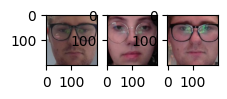

In [6]:
#Show the processed images
da_list = []


for (dirp, dirn, filen) in os.walk(data_home):
    da_list.extend(filen)
    break

plt.figure(figsize=(len(da_list),len(da_list)))

break_iter = 0
for iter,file in enumerate(da_list):
    plt.subplot(1+len(da_list)//3,1+len(da_list)%5,iter+1)
    # define filename
    # load image pixels
    image = plt.imread(os.path.join(data_home,file))
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

## Bring the Images into a format Tensorflow can Understand

In [7]:
IMG_SIZE=64     #Img size
ROWS = 256      #Img size
COLS = 256      #Img size
CHANNELS = 3    #RGB
batch_size=64   #What was shown as a good number for back propogation in AlexNet


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "hotf/data",
  validation_split=0, 
  seed=RANDOM_SEED,
  image_size=(ROWS, COLS),
  batch_size=batch_size)

Found 3 files belonging to 1 classes.


# Load the Model

In [8]:
# Create a new model instance
model = tf.keras.models.load_model('MSE1')

model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use mean squared error for regression
              metrics=['mean_absolute_error']) 


1/1 [==============================] - 0s 267ms/step
The model estimates this person is 62.73 years old


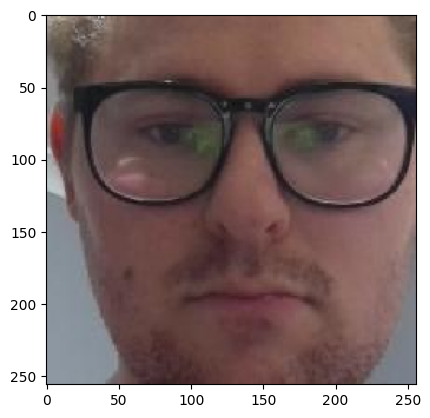

1/1 [==============================] - 0s 52ms/step
The model estimates this person is 55.94 years old


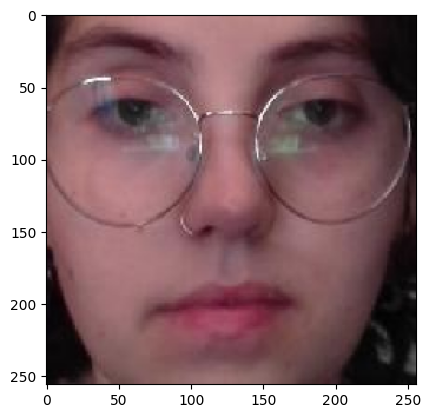

1/1 [==============================] - 0s 44ms/step
The model estimates this person is 72.36 years old


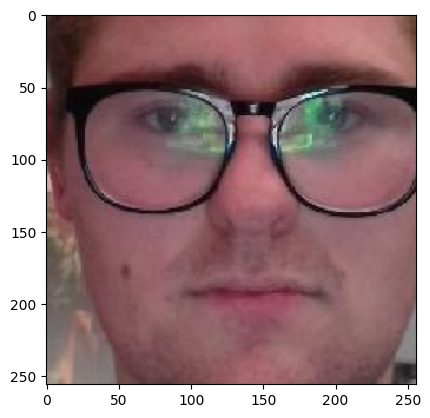

In [9]:
for file in os.listdir(data_home):
    src = os.path.join(data_home,file)
    
    img = keras.preprocessing.image.load_img(
        src, target_size=(ROWS, COLS))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img_array[0,...].numpy().astype("uint8"))

    predictions = model.predict(img_array)
    
    print(
        "The model estimates this person is {:.2f} years old"
        .format(float(str(predictions)[2:-2]))
    )
   
    plt.show()